In [92]:
import pandas as pd
import matplotlib as mpl
from scipy import stats
import scipy.special
import os
from scipy import constants
from colossus.cosmology import cosmology
from astropy.cosmology import z_at_value
from astropy import units as unit
from astropy.coordinates import SkyCoord
from calculation_method import *
params = {'flat': True, 'H0': 67.77, 'Om0': 0.307, 'Ob0': 0.04825, 'sigma8': 0.8288, 'ns': 0.9611}
cosmology.addCosmology('planck14', params)
cosmo = cosmology.setCosmology('planck14')
import scipy.stats
import pandas as pd

In [93]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, FixedLocator
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use("shao.mplstyle")
fontSize = 15
lineWidth = 1.5

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', \
          u'#bcbd22', u'#17becf']

In [94]:
# central_R200_l = np.loadtxt('central_R200.txt')
# simulation_num_l = [1,2,3,4]
# simulation = 'zcut7'

In [95]:
R_max = 300.  # physical kpc
Mstar_min = 100.  # in solar masses
stack=True

In [96]:
# specify for which entries below to calculate the satellite positions at each redshift
#systems = [16, 17, 18, 19]
systems = [0,1, 2,3]

# central galaxy index (i.e.) position in the Galform file (one entry per system)
# only needed for the systems where the central is not a type=0 galaxy with the largest halo mass
# index of the galaxy in the Galform file dataset 'Output001'

simulation_names = [
    "M1_zcut7",
    "M2_zcut7",
    "M3_zcut7",
    "M4_zcut7",
    "M5_zcut7",
    "M1_7DM_GAS",
    "M2_7DM_GAS",
    "M3_7DM_GAS",
    "M4_7DM_GAS",
    "M5_7DM_GAS"
]

centralIndeces = [
    0,    # M1_zcut7
    0,    # M2_zcut7
    0,    # M3_zcut7
    518,  # M4_zcut7
    79,   # M5_zcut7
    0,    # M1_7DM_GAS
    387,  # M2_7DM_GAS
    0,    # M3_7DM_GAS
    581,  # M4_7DM_GAS
    0,    # M5_7DM_GAS
]

# path to the input files
root_galfromFiles = "/home/zhaox/Magpie/Galform/"
list_galformFiles = [
    "M1_zcut7/galaxies.hdf5",
    "M2_zcut7/galaxies.hdf5",
    "M3_zcut7/galaxies.hdf5",
    "M4_zcut7/galaxies.hdf5",
    "M5_zcut7/galaxies.hdf5",
    "M1_7DM_GAS/galaxies.hdf5",
    "M2_7DM_GAS/galaxies.hdf5",
    "M3_7DM_GAS/galaxies.hdf5",
    "M4_7DM_GAS/galaxies.hdf5",
    "M5_7DM_GAS/galaxies.hdf5",
]

# path to the input particle data files
root_subhaloFiles = "/cosma7/data/dp004/dc-shao1/Magpie/data/outputs/"
list_subhaloFiles = [
    "M1_zcut7/groups_%03i_z???p???/",
    "M2_zcut7/groups_%03i_z???p???/",
    "M3_zcut7/groups_%03i_z???p???/",
    "M4_zcut7/groups_%03i_z???p???/",
    "M5_zcut7/groups_%03i_z???p???/",
    "M1_7DM_GAS/groups_%03i_z???p???/",
    "M2_7DM_GAS/groups_%03i_z???p???/",
    "M3_7DM_GAS/groups_%03i_z???p???/",
    "M4_7DM_GAS/groups_%03i_z???p???/",
    "M5_7DM_GAS/groups_%03i_z???p???/",
]

# path to the output 
root_satelliteFiles = "/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/"
list_satelliteFiles = [
    "M1_MR.hdf5",
    "M2_MR.hdf5",
    "M3_MR.hdf5",
    "M4_MR.hdf5",
    "M5_MR.hdf5",
    "M1_7DM_GAS.hdf5",
    "M2_7DM_GAS.hdf5",
    "M3_7DM_GAS.hdf5",
    "M4_7DM_GAS.hdf5",
    "M5_7DM_GAS.hdf5",
]

# path to the output files for figures
plotFigures = True
root_plotFiles = "./fig/"
list_plotFiles = [
    "M1_MR_orbits.pdf",
    "M2_MR_orbits.pdf",
    "M3_MR_orbits.pdf",
    "M4_MR_orbits.pdf",
    "M5_MR_orbits.pdf",
    "M1_7DM_GAS_orbits.pdf",
    "M2_7DM_GAS_orbits.pdf",
    "M3_7DM_GAS_orbits.pdf",
    "M4_7DM_GAS_orbits.pdf",
    "M5_7DM_GAS_orbits.pdf",
]

if systems is None:
    systems = list(range(len(centralIndeces)))

dm_halo_minor_l = np.array([[-0.22037225,  0.9744935 ,   0.04240861],
            [0.18181571,   0.42799015,  -0.88530643],
            [0.30559745,   0.3931947 ,   0.86718402],
            [0.27163464,  -0.00129548,  -0.96239958],
            [0.17690542,   0.04002508,  -0.98341368]])

# 1 read data

In [97]:
def read_satellite_orbit_Galform(satelliteFile):
# within 300kpc, > mass_min, after tidal destruction

    with h5py.File(satelliteFile, 'r' ) as hf:
        # data = hf[inputFile]
        # print ("data.keys = " , data.keys())
        # gid = data['GalaxyID'][:]
        # num = len(gid)
        # print("hf.keys()", hf.keys())
        # print("hf/satellite_galaxies.keys()",hf['satellite_galaxies'].keys())
        t = hf["header_info/time"][:]
        a = hf["header_info/scale_factor"][:]
        h = hf['header_info/h'][()].astype(np.float64)
        z = hf["header_info/redshift"][:]
        # central_Mhalo = hf['central_galaxy/Mhalo'][:]
        satellite_mstar = hf['satellite_galaxies/Mstar'][:]
        # satellite_msub = hf['satellite_galaxies/Msub'][:]
        # satellite_mhalo = hf['satellite_galaxies/Mhalo'][:]
        satellite_pos = hf['satellite_galaxies/pos'][:]
        # central_pos = hf['satellite_galaxies/pos'][:]
        satellite_vel = hf['satellite_galaxies/vel'][:]
        # satellite_R200 = hf['satellite_galaxies/R200'][:]
        # is_MW_central = hf['satellite_galaxies/is_MW_central'][:]
        # Last snapshot at which the galaxy is a FOF central subhalo. Different from Galform definition of central galaxy.
        # satellite_snap_last_FOF_central = hf['satellite_galaxies/snap_last_FOF_central'][:]
        # Last snapshot at which the galaxy was a central.
        # satellite_snap_last_central = hf["satellite_galaxies/snap_last_central"][:]
        # satellite_type = hf["satellite_galaxies/type"][:]
        destruction = hf["tidal_disruption/destroyed_orbit_interpolation"][:]
    # print("d<300,m>0 satellite num=", len(satellite_mstar))
    
    distance_z0 = np.linalg.norm(satellite_pos[:,0,:], axis=1)
    print("d<300,m>100 satellite num=", sum((satellite_mstar[:,0]>=Mstar_min) & (distance_z0<=R_max)))
    # R200 = 227.2 * (central_Mhalo/1.252e12)**0.3333
    
    is_satellite = (satellite_mstar[:,0]>=Mstar_min) & (destruction==False) & (distance_z0<=R_max)
    satellite_mstar = satellite_mstar[is_satellite]
    satellite_pos = satellite_pos[is_satellite]
    # satellite_mhalo = satellite_mhalo[is_satellite]
    satellite_vel = satellite_vel[is_satellite]
    # satellite_R200 = satellite_R200[is_satellite]
    print("d<%d,m>%d after destruction satellite num="%(R_max, Mstar_min), sum(is_satellite))
    return satellite_mstar, satellite_pos, satellite_vel, t, a, h, z

In [98]:
def read_satellite_hydro_z0(simulation_num, simulation_name, maxn):
    # read the subgroup catalogue
    # inputFile_root = "groups_199_z000p000/eagle_subfind_tab_028_z000p000.%i.hdf5" 
    file = simulation_name
    inputFile_root = '/home/zhaox/Magpie/' + file + '/groups_199_z000p000/eagle_subfind_tab_199_z000p000.%i.hdf5'
    # read the data - read the first tab file to get the total number of subgroups
    inputFile = inputFile_root % 0

    # 对于4和5，中央星系的galaxyID不等于0

    if simulation_name[3:] == 'zcut7':
        if simulation_num == 4:
            centerIndex = 2
        elif simulation_num == 5:
            centerIndex = 2
        else:
            centerIndex = 1
    elif simulation_name[3:] == '7DM_GAS':
        if simulation_num == 2:
            centerIndex = 2
        elif simulation_num == 4:
            centerIndex = 3
        else:
            centerIndex = 1
    else:
        print("can't understand simulation_name!")
        return
    with h5py.File( inputFile, 'r' ) as hf:
        header  = hf['Header'].attrs
        # print ('header keys:', header.keys())
        numFiles = header['NTask']  # this gives the number of files in which the group catalog is saved
        noTotGrps = header['TotNgroups']  # total number of FOF groups
        noTotSubs = header['TotNsubgroups']  # total number of SUBFIND subhaloes
        hFactor   = header['HubbleParam']
        # print("All groups in the file:", hf.keys())
        # print("All entries in the 'FOF' group:", hf['FOF'].keys())
        # print("All entries in the 'SubHalo' group:", hf['Subhalo'].keys())
        # print(numFiles, noTotGrps, noTotSubs, hFactor)


    # reserve memory for the output arrays
    FOF_length   = np.zeros( noTotGrps, np.uint32 )
    FOF_mass     = np.zeros( noTotGrps, np.float32 )
    FOF_pos      = np.zeros( (noTotGrps,3), np.float32 )  # centre of potential
    FOF_M200     = np.zeros( noTotGrps, np.float32 )
    FOF_R200     = np.zeros( noTotGrps, np.float32 )
    Subhalo_mass = np.zeros( noTotSubs, np.float32 )
    Subhalo_pos  = np.zeros( (noTotSubs,3), np.float32 )  # centre of potential
    Subhalo_vel = np.zeros( (noTotSubs,3), np.float32 )
    Subhalo_gnum = np.zeros( noTotSubs, np.float32 )

    # loop over all the various files
    start, end = 0, 0
    start2, end2 = 0, 0
    for i in range(numFiles):
        inFile = inputFile_root % i
        with h5py.File( inFile, 'r' ) as hf:
            h = hf['Header'].attrs
            numGrps = h['Ngroups']  # number of groups this file
            numsubGrps = h['Nsubgroups']
            end = start + numGrps
            end2 = start2 + numsubGrps
    #         print(numsubGrps)
            # print ("Reading file %i of %i --%s-- which contains %i groups ..." % ( i+1, numFiles, inFile, numGrps ))
            
            # FOF_length[start:end] = hf["FOF/GroupLength"]
            # FOF_mass[start:end] = hf["FOF/GroupMass"]
            FOF_pos[start:end]  = hf["FOF/GroupCentreOfPotential"]
            # FOF_M200[start:end] = hf["FOF/Group_M_Crit200"]
            FOF_R200[start:end] = hf["FOF/Group_R_Crit200"]
            Subhalo_pos[start2:end2] = hf["Subhalo/CentreOfPotential"]
            Subhalo_mass[start2:end2] = hf["Subhalo/MassType"][:,4]
            Subhalo_vel[start2:end2] = hf["Subhalo/Velocity"]
            Subhalo_gnum[start2:end2] = hf["Subhalo/GroupNumber"]
            start = end
            start2 = end2
    Subhalo_pos = (Subhalo_pos - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_index = []
    dis = []
    for i in range(len(Subhalo_pos)):
        dis_ = ((Subhalo_pos[i][0]**2 + Subhalo_pos[i][1]**2 + Subhalo_pos[i][2]**2)**0.5)
        # 筛选条件小于300kpc，大于100msun
        # print(dis_)
        if  dis_  < 300 and Subhalo_mass[i] > 0:
            satellite_index.append(i)
            dis.append(dis_)
    # print(satellite_index)
    # 选择groupNumber==centerindex的星系
    # satellite_index = np.where(Subhalo_gnum == centerIndex)

    # print(satellite_index)
    print('r200 = ',FOF_R200[centerIndex-1])
    #计算相对坐标和相对速度
    # satellite_pos = (Subhalo_pos[satellite_index] - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_pos = Subhalo_pos[satellite_index]
    satellite_vel = Subhalo_vel[satellite_index] - Subhalo_vel[satellite_index][0]
    dis = np.linalg.norm(satellite_pos, axis = 1)
    satellite_data =pd.DataFrame({"groupNumber":Subhalo_gnum[satellite_index], "id":satellite_index,\
            "mass":Subhalo_mass[satellite_index]*1e10/hFactor, "distance[kpc]":dis, \
            "x[kpc]":satellite_pos[:,0],"y[kpc]":satellite_pos[:,1],"z[kpc]":satellite_pos[:,2],\
            "vx[km/s]":satellite_vel[:,0],"vy[km/s]":satellite_vel[:,1],"vz[km/s]":satellite_vel[:,2]},  \
        columns=['groupNumber', 'id', 'mass', 'distance[kpc]', 'x[kpc]', 'y[kpc]', 'z[kpc]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'])
        # 返回显示质量最大的maxn个,maxn=1000表示输出所有满足条件的星系，从1开始是因为0是中央星系
    # satellite_data = all_data[all_data['groupNumber'] == centerIndex+1] 
    # satellite_data = satellite_data.query("mass > 0 & `distance[kpc]` < 300")
    # satellite_index = np.where(satellite_data['groupNumber'] == centerIndex)
    # satellite_data = satellite_data.iloc[satellite_index]
    satellite_data = satellite_data.sort_values(by=['mass'],ascending=False)
    # satellite_data = satellite_data.loc[satellite_data['distance[kpc]']<300 ]
    satellite_pos = np.array(satellite_data[['x[kpc]','y[kpc]','z[kpc]']])
    satellite_vel = np.array(satellite_data[['vx[km/s]','vy[km/s]','vz[km/s]']])
    
    print('center pos:', FOF_pos[centerIndex-1], "satellite num = ", len(satellite_pos)-1)
    return FOF_R200[centerIndex-1], satellite_data.iloc[:maxn+1], satellite_pos[1:maxn+1], satellite_vel[1:maxn+1]
    # return satellite_data.sort_values(by=['mass'],ascending=False).iloc[:]

In [99]:
def draw_L_CDF(angle_l, save=False, title=None):

    def bootstrap_error(data):
        sample_size = len(data)
        n_sample = 100
        sample_l = np.zeros((n_sample, sample_size))
        for i in range(n_sample):
            sample = np.random.choice(data, size=sample_size, replace=True)
            sample.sort()
            sample_l[i] = sample
        stds = np.std(sample_l, axis=0)
        n = 19
        step = (sample_size-1) / (n-1)
        index = []
        for i in range(n):
            index.append(int(i* step+ 0.5))
        return stds[index]

    hist_bins = np.arange(0,1.05,0.05)
    index_l = [r'$>10^6M_{\odot}$',r'$>10^5M_{\odot}$',r'$>10^4M_{\odot}$',r'$>10^3M_{\odot}$',r'$>10^2M_{\odot}$']
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), color = 'red', linestyle = '--', label = 'uniform')
    plt.axvline(x = np.cos(np.deg2rad(36.87)), color = 'y', alpha = 0.6,  label = r'36.87$^\circ$, co-orbit=%.2f%%'%(100*sum(angle_l[-2]>(np.cos(36.87/180*np.pi)))/len(angle_l[-2])))
    for i in range(len(angle_l)):
        h_1,xedge = np.histogram(angle_l[i],hist_bins)
        index = index_l[i]
        cdf = np.concatenate(([0],np.cumsum(h_1)/np.sum(h_1)))
        std = np.concatenate(([0],bootstrap_error(angle_l[i]),[0]))
        e1, = ax.plot(xedge,cdf, label = f'{index}, num='+str(len(angle_l[i])))
        if i in [0, 1, 2, 4,5]:
            ax.fill_between(xedge, cdf, cdf-std, color = e1.get_color(), alpha = 0.3)
            ax.fill_between(xedge, cdf, cdf+std, color = e1.get_color(), alpha = 0.3)

    # if (e3_2 == gal_c_a_minor).all():
    #     axis = 'c_a_minor'
    ax.set_xlabel(r'cos<$L\cdot n_{c/a-minor,z=0}$>')
    # elif (e3_2 == gal_alpha_axis).all():
    #     axis = 'alpha-axis'
    #     ax.set_xlabel(r'cos<$L\cdot n_{\alpha8-axis,z=0}$>')
    # elif (dm_halo_minor[simulation_num-1]).all():
    #     axis = 'dmhalo-minor'
    #     ax.set_xlabel(r'cos<$L\cdot n_{dmhalo-minor,z=0}$>')

    # ax.set_xlabel(r'cos<$L\cdot n_{orbitalpole,z=0}$>')
    ax.set_ylabel('CDF')
    # ax.set_title(simulation_name)
    # ax.set_title('M1-M4')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.legend(fontsize = 10)
    if save ==True:
        plt.savefig("fig/" + title + ".png", dpi=300)


def draw_lbtime_PDF(infall_index, save=False, title=None):
    z = 1/a - 1
    z_infall = z[infall_index]
    infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall])

    from matplotlib.ticker import MaxNLocator
    # plt.title(simulation_name + ' infall time PDF')
    plt.figure()
    ax1 = plt.gca()
    bins = np.linspace(0,14,15)
    N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.8, histtype='step', linewidth=3)
    ax1.set_xlabel('lookback time/[Gyr]')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax1.arrow(lbtime[0],2, 0, -1, width = 0.1, color = 'red')
    # ax1.text(lbtime[0]+1,2.5, "lmc infall", fontsize=13)
    # ax1.arrow(lbtime[1],2, 0, -1, width = 0.1, color = 'red')
    # ax1.text(lbtime[1]+1,2.5, "smc infall", fontsize=13)
    # ax1.invert_xaxis()
    # sort = np.argsort(satellite_mstar[is_within_r200,0])
    # ax1.arrow(infall_lbtime[sort[-1]],2, 0, -1, width = 0.1, color = 'orange')
    # ax1.text(infall_lbtime[sort[-1]]+1,2.5, "lmc infall", fontsize=13)
    # ax1.arrow(infall_lbtime[sort[-2]],2, 0, -1, width = 0.1, color = 'orange')
    # ax1.text(infall_lbtime[sort[-2]]+1,2.5, "smc infall", fontsize=13)

    ax1.set_xlim(14,0)

    # for i in range(1,5):
    #     patches[-i].set_facecolor('c')

    def lbtime2z(lbtime):
        t_universe = cosmo.age(0)
        z = cosmo.age(t_universe - lbtime, inverse = True)
        return ["%.1f" % z_ for z_ in z]

    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    new_tick_locations = np.array([0.01, cosmo.lookbackTime(0.2), cosmo.lookbackTime(0.5), cosmo.lookbackTime(1), cosmo.lookbackTime(2), cosmo.lookbackTime(3), cosmo.lookbackTime(5)])
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(lbtime2z(new_tick_locations))
    # ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # ax2.xtick.minor.visible:=False
    # ax.xaxis.set_minor_locator([])
    ax2.minorticks_off()
    ax2.set_xlabel('z')
    ax1.set_ylabel('satellite number')
    if save:
        plt.savefig('fig/'+title + ' infall time PDF.png', dpi=300)

------------------------------------------------------------------------------------------------
Reading system '0' info from the file '/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M1_MR.hdf5' ...
d<300,m>100 satellite num= 121
d<300,m>100 after destruction satellite num= 86


/tmp/ipykernel_92434/2687898567.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  angle_l = np.array([angle_L_to_axis[satellite_mstar[:,0]>1e6],


c/a= 0.24688983486106478 
 α8= 27.83088503540279
angle between =  15.921774137962919
------------------------------------------------------------------------------------------------
Reading system '1' info from the file '/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M2_MR.hdf5' ...
d<300,m>100 satellite num= 136
d<300,m>100 after destruction satellite num= 98
c/a= 0.3462328418035844 
 α8= 40.63018002002118
angle between =  48.48053848327809
------------------------------------------------------------------------------------------------
Reading system '2' info from the file '/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M3_MR.hdf5' ...
d<300,m>100 satellite num= 181
d<300,m>100 after destruction satellite num= 94
c/a= 0.25869326653588803 
 α8= 40.539527345084224
angle between =  28.90961595156217
------------------------------------------------------------------------------------------------
Reading system '3' info from the file '/home/zhaox/Magpie/Destruction/satell

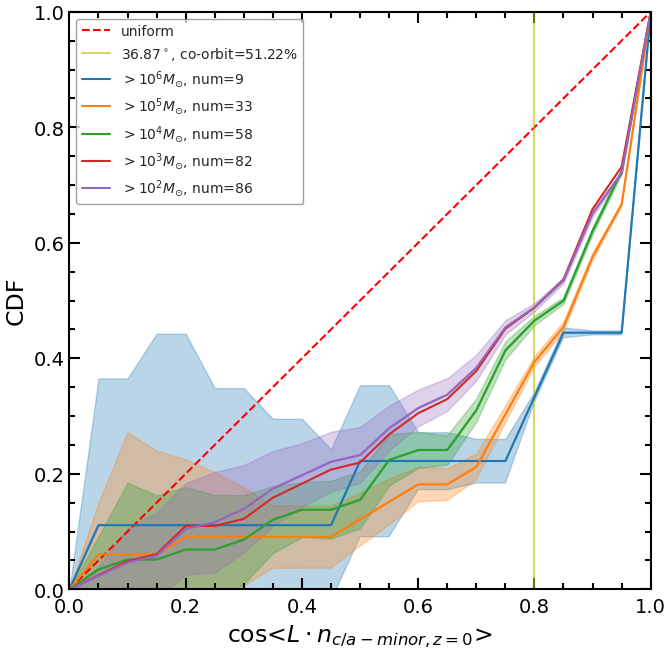

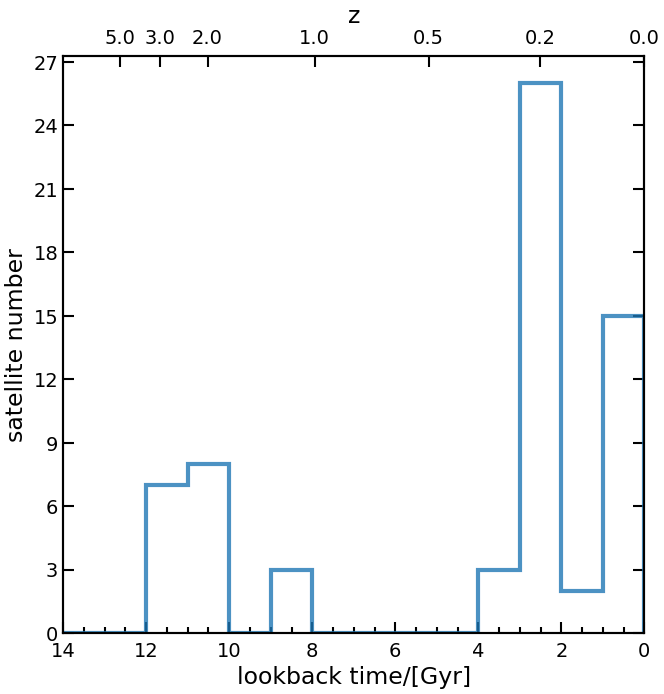

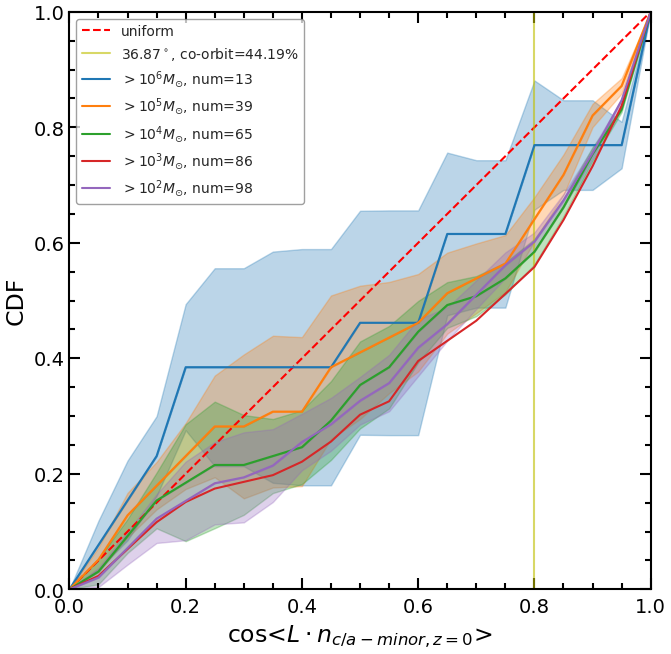

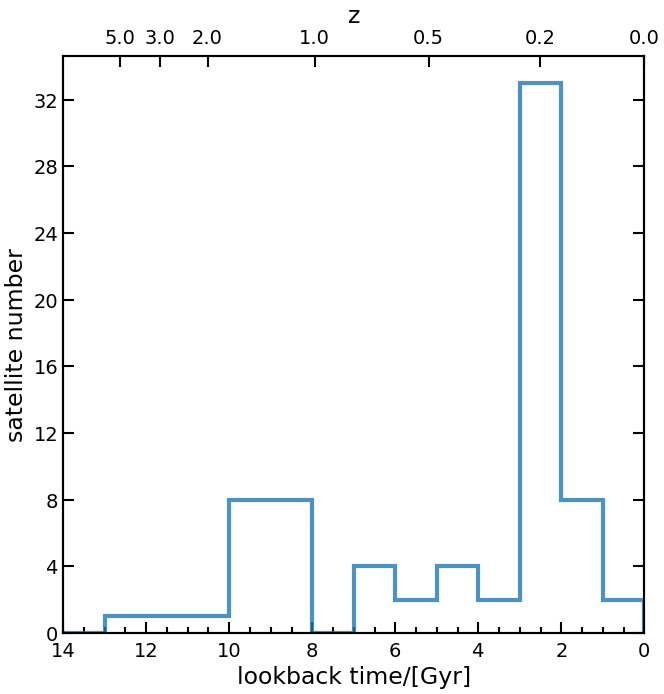

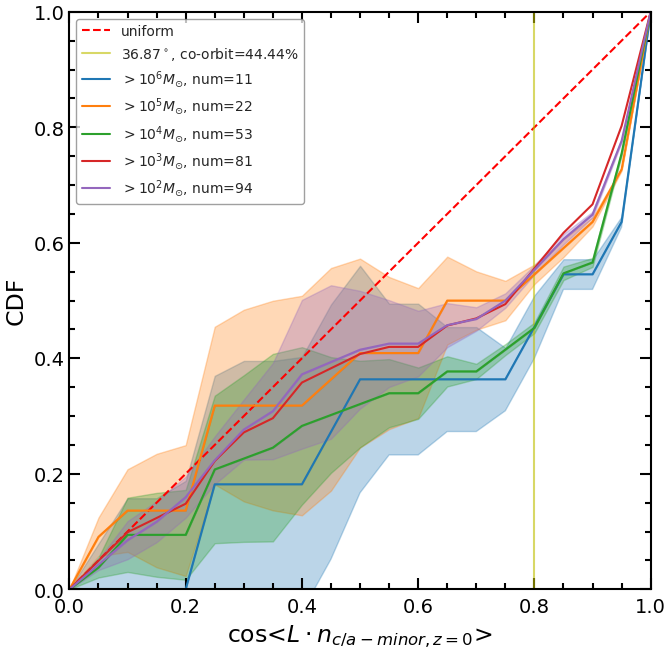

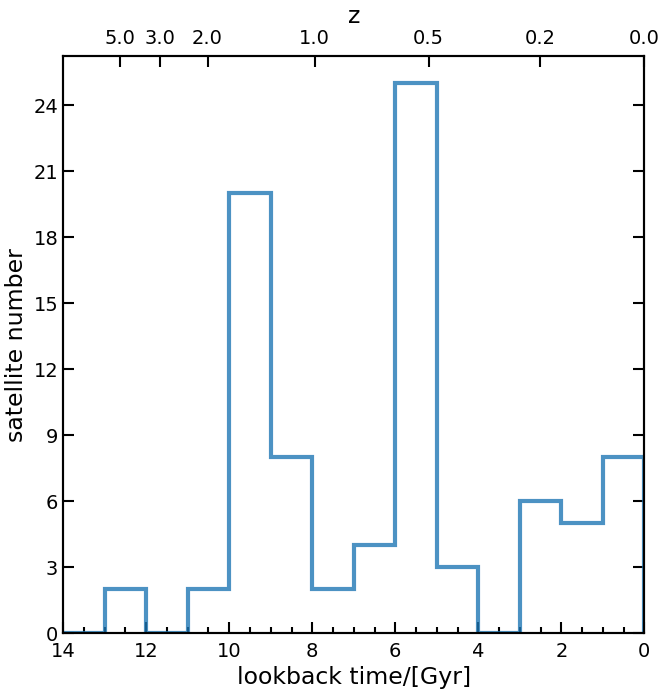

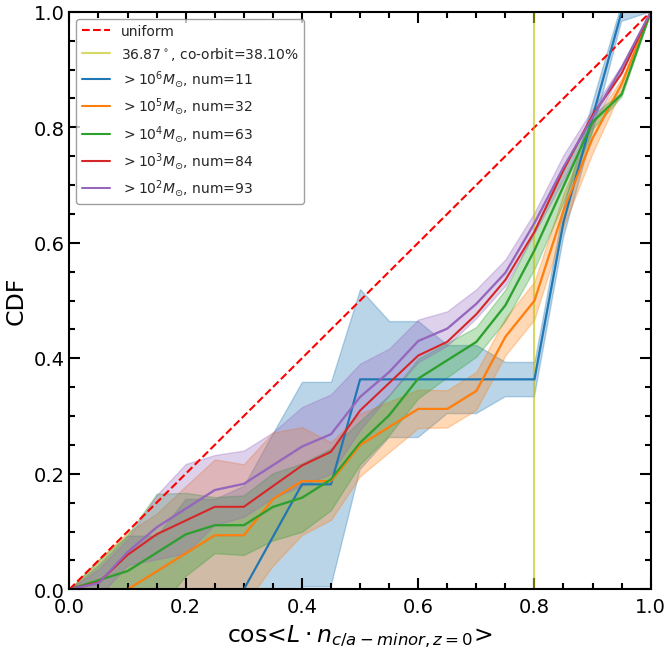

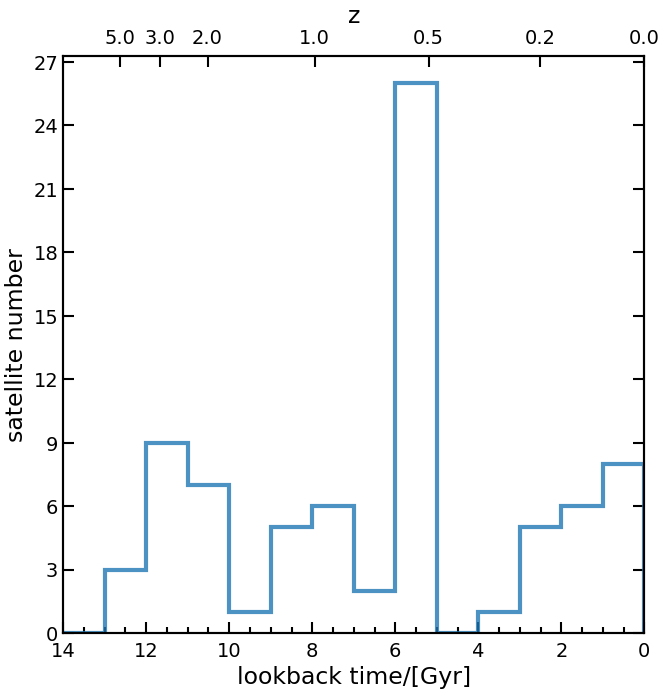

In [100]:
# %matplotlib agg

# angle_l_stack = [np.array([]),np.array([]),np.array([]),np.array([]),np.array([])]

angle_l_stack = [[],[],[],[],[]]
infall_index_stack = []
# for i in range(len(systems)):
#     infall_index_stack.append([])

for system in systems:
    # read_satellite_orbit_Galform
    satelliteFile = root_satelliteFiles + list_satelliteFiles[system]
    print('------------------------------------------------------------------------------------------------')
    print("Reading system '%i' info from the file '%s' ..." %
          (system, satelliteFile))
    satellite_mstar, satellite_pos, satellite_vel, \
        t, a, h, z =  read_satellite_orbit_Galform(satelliteFile)
    L = np.cross(satellite_pos, satellite_vel)
    satellite_num = len(satellite_pos)
    simulation_name = simulation_names[system]
    central_R200 = np.loadtxt('./data/mw_r200_' + simulation_name)


    # analyse z=0 after destruction
    L_z0 = L[:,0,:]
    L_z0 = L_z0 / np.linalg.norm(L_z0, axis=1)[:, np.newaxis] # normalization
    sort = np.argsort(satellite_mstar[:,0]) # from faint to massive
    Top11_index = sort[-11:]
    c_a, gal_c_a_minor = cal_c_a_ratio(satellite_pos[Top11_index,0,:])
    alpha, gal_alpha_axis = cal_alpha(L_z0[Top11_index])
    angle_L_to_axis = abs(np.dot(L_z0, gal_c_a_minor))
    angle_l = np.array([angle_L_to_axis[satellite_mstar[:,0]>1e6],  
                        angle_L_to_axis[satellite_mstar[:,0]>1e5],
                        angle_L_to_axis[satellite_mstar[:,0]>1e4],
                        angle_L_to_axis[satellite_mstar[:,0]>1e3],
                        angle_L_to_axis[satellite_mstar[:,0]>1e2]])
    print("c/a=", c_a, "\n", chr(945)+"8=", alpha)
    print("angle between = ", cal_angle(gal_c_a_minor, gal_alpha_axis))

    draw_L_CDF(angle_l)


    # read hydro data
    dm_halo_minor = dm_halo_minor_l[system]
    # central_R200_z0, hydro_satellite_data, hydro_pos, hydro_vel = read_hydro(simulation_num, simulation_name, maxn=1000)
    # axis_num = 5
    # e_l = np.zeros((axis_num,3))
    # e_l[0] = dm_halo_minor[simulation_num-1]
    # e_l[1] = gal_c_a_minor
    # e_l[2] = gal_alpha_axis

    # c_a, e_l[3]  = cal_c_a_ratio(hydro_pos[:11])
    # hydro_L = np.cross(hydro_pos, hydro_vel)
    # for i in range(len(hydro_L)):
    #     hydro_L[i] = hydro_L[i] / np.linalg.norm(hydro_L[i])
    # angle_hydro_L = abs(np.dot(hydro_L, e_l[3])).tolist()
    # alpha, e_l[4] = cal_alpha(hydro_L[:11])
    # print('hydro: c/a=', c_a, "\n", chr(945)+"8=", alpha)
    # print("angle between = ", cal_angle(e_l[3], e_l[4]))


    # analyse infall time and L infall
    is_within_r200 = np.linalg.norm(satellite_pos[:,0], axis=1)<central_R200[0]
    satellite_mstar_r200 = satellite_mstar[is_within_r200]
    satellite_pos_r200 = satellite_pos[is_within_r200]
    satellite_vel_r200 = satellite_vel[is_within_r200]
    lookbackTime = cosmo.age(0) - t
    satellite_num_r200 = len(satellite_pos_r200)
    dis_l = np.zeros((satellite_num_r200,199))
    infall_index = np.zeros(satellite_num_r200 , dtype=int)
    for i in range(satellite_num_r200):
        for j in range(199):
            dis_l[i][j] = np.linalg.norm(satellite_pos_r200[i][j])
            if (dis_l[i][j]> central_R200[j] and infall_index[i]==0):
                infall_index[i] = j
    draw_lbtime_PDF(infall_index)


    if stack:
        for i in range(len(angle_l)):
            angle_l_stack[i] = np.concatenate((angle_l_stack[i], angle_l[i]))
        infall_index_stack.append(infall_index)
        # infall_index_stack[system] = infall_index

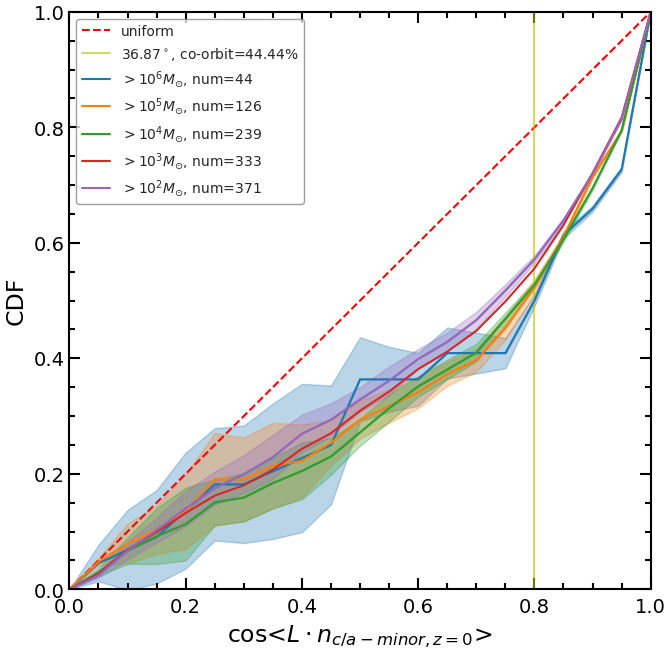

In [101]:
draw_L_CDF(angle_l_stack, save=True, title='zcut7_angle_l_stack')

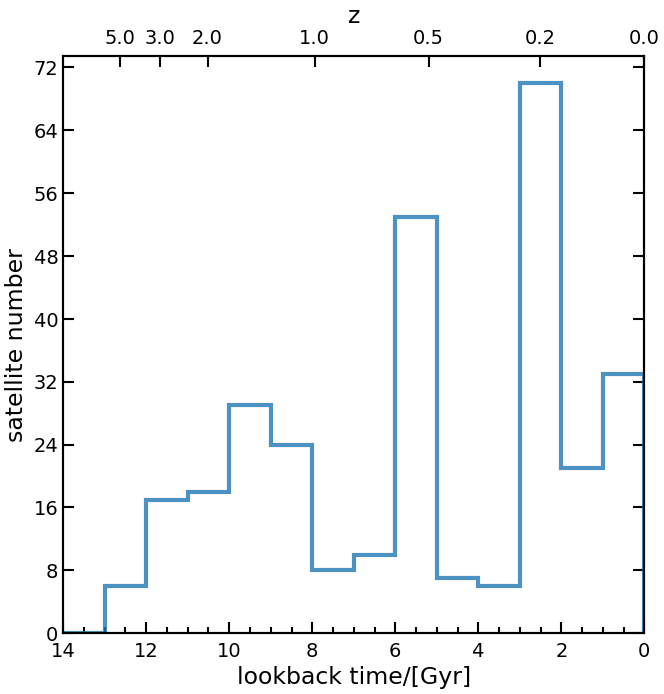

In [102]:
draw_lbtime_PDF(np.concatenate(infall_index_stack), save=True, title="zcut7_infall_time_stack")

In [68]:
infall_index_stack

[array([  2,  19,  22,   7,  19,  23,   5,   1,  22,  16,  68,  22,   1,
          6,  26,  14,  31,  23,   6,  18,   9,  70,  98, 104,  23,   1,
        105, 109, 106, 111,  29, 118,  19,   2,  22, 103, 112,  20,   1,
          2,  21,  23,  23,  70,  22,   1,  22, 112,  22,   4,   1, 128,
         22,  21,   2, 104,  22, 121,  96,  22,  97,  22,  22,  23]),
 array([ 11,  15,  15,  19,  20,   2,   5,  22,  34,  21,  34,  14,  23,
         18,  18,  22,  17,  22,  19,  17,  49,  36,  83,  29,  18,  22,
         40,  19,  15,  53,  19,  37,  71,  18,  75,  20,  55,  18,  19,
         79,  43,  74,  13,  78,  86, 113,  10,  80,  99,  20,  12,  82,
         74,  18,  74,  79,  49,  83,  19,  18,  16, 138,  18,  20,  74,
         74,  19,  30,  16,  19,  18,  19,  20,  74]),
 array([  9,   2,  42,  10,  10,   5,  44,  35,  18,  21,  49,  33,  32,
          6,  44,  68,  13,  65,  44,  42,  40,  77,  14,  51,  79,   3,
          2,  83,  89,  72,  87,  53,  43,  21,  82,  43,  43,  20,  44,

In [202]:
def draw_cdf(data,legends, title, xlabel, save=False, title=None):
    hist_bins = np.arange(0,1.05,0.05)
    index_l = legends

    fig = plt.figure()
    ax = fig.add_subplot()
    # ax.step((xedge[1:]+xedge[:-1])/2.,(h_phe)/np.sum(h_phe),'r-',where='mid')
    # ax.set_xlabel(r'$\Delta RV_{max}$ (km s$^{-1}$)',fontsize=12)
    ax.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), color = 'red', linestyle = '--', label = 'uniform')

    for i in range(len(data)):
        # index = index_l[i]
        h_1,xedge = np.histogram(data[i],hist_bins)
        index = index_l[i]
        # print(y_fit)
        cdf = np.concatenate(([0],np.cumsum(h_1)/np.sum(h_1)))
        e1, = ax.plot(xedge,cdf, label = f'{index}')
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    # ax.set_title(title)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.legend(fontsize = 10)
    if save == True:
        plt.savefig('fig/' + title +'.png', dpi=300)

In [204]:
# central_R200 = np.loadtxt('data/central_r200_'+ simulation_name)

In [ ]:
infall_index

array([ 11,  15,  15,  19,  20,   2,   5,  22,  34,  21,  34,  14,  23,
        18,  18,  22,  17,  22,  19,  17,  49,  36,  83,  29,  18,  22,
        40,  19,  15,  53,  19,  37,  69,  18,  69,  20,  55,  18,  19,
        79,  43,  74,  13,  69,  86, 116,  10,  80,  99,  20,  12,  82,
        74,  18,  74,  69,  49,  83,  19,  18,  16, 138,  18,  20,  74,
        74,  19,  30,  16,  19,  18,  19,  20,  74])

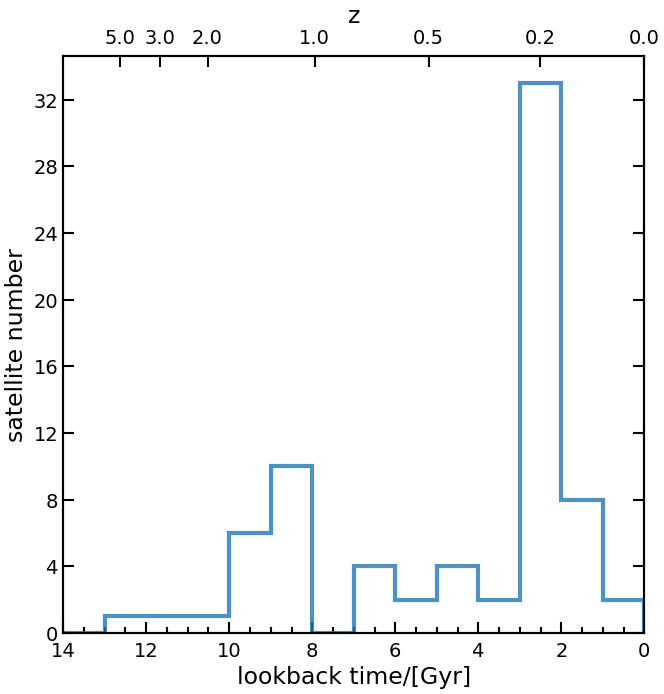

In [ ]:
z = 1/a - 1
z_infall = z[infall_index]
infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall])

from matplotlib.ticker import MaxNLocator
# plt.title(simulation_name + ' infall time PDF')
ax1 = plt.subplot()
bins = np.linspace(0,14,15)
N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.8, histtype='step', linewidth=3)
ax1.set_xlabel('lookback time/[Gyr]')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax1.arrow(lbtime[0],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[0]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(lbtime[1],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[1]+1,2.5, "smc infall", fontsize=13)
# ax1.invert_xaxis()
sort = np.argsort(satellite_mstar[is_within_r200,0])

# ax1.arrow(infall_lbtime[sort[-1]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-1]]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(infall_lbtime[sort[-2]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-2]]+1,2.5, "smc infall", fontsize=13)

ax1.set_xlim(14,0)

# for i in range(1,5):
#     patches[-i].set_facecolor('c')

def lbtime2z(lbtime):
    t_universe = cosmo.age(0)
    z = cosmo.age(t_universe - lbtime, inverse = True)
    return ["%.1f" % z_ for z_ in z]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
new_tick_locations = np.array([0.01, cosmo.lookbackTime(0.2), cosmo.lookbackTime(0.5), cosmo.lookbackTime(1), cosmo.lookbackTime(2), cosmo.lookbackTime(3), cosmo.lookbackTime(5)])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(lbtime2z(new_tick_locations))
# ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax2.xtick.minor.visible:=False
# ax.xaxis.set_minor_locator([])
ax2.minorticks_off()
ax2.set_xlabel('z')
ax1.set_ylabel('satellite number')
plt.savefig('fig/'+simulation_name + ' infall time PDF.png', dpi=300)

In [ ]:
early_infall_galaxy = np.where(infall_lbtime>8)[0]
late_infall_galaxy = np.where(infall_lbtime<6)[0]
born_infall_galaxy = np.where(z_infall>3.0)[0]
set_born_infall_galaxy = set(born_infall_galaxy)
early_infall_galaxy_remove_born_infall = np.array([x for x in early_infall_galaxy if x not in set_born_infall_galaxy])
print(early_infall_galaxy_remove_born_infall, '\n', late_infall_galaxy)

[22 32 34 39 41 43 44 45 47 48 51 52 54 55 57 64 65 73] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 23 24 25
 26 27 28 30 31 33 35 37 38 40 42 46 49 50 53 58 59 60 62 63 66 67 68 69
 70 71 72]


In [ ]:
satellite_L_infall = np.zeros((satellite_num_r200,3))
satellite_L_r200 = np.cross(satellite_vel_r200, satellite_pos_r200)
for i in range(len(satellite_L_r200)):
    # satellite_L_r200[i] = satellite_L_r200[i]/ np.linalg.norm(satellite_L_r200[i])
    satellite_L_infall[i] = satellite_L_r200[i][infall_index[i]]

In [ ]:
satellite_L_r200.shape

(74, 199, 3)

In [ ]:
satellite_vel_r200.shape

(74, 199, 3)

In [ ]:
# e3_2 = dm_halo_minor[simulation_num-1]
e3_2 = gal_c_a_minor
# e3_2 = gal_alpha_axis
satellite_L_r200_infall_late = satellite_L_infall[late_infall_galaxy]
satellite_L_r200_infall_late = satellite_L_r200_infall_late/np.linalg.norm(satellite_L_r200_infall_late, axis=1, keepdims=True)
angle_r200_infall_late = abs(np.dot(satellite_L_r200_infall_late, e3_2))

satellite_L_r200_infall_early = satellite_L_infall[early_infall_galaxy]
satellite_L_r200_infall_early = satellite_L_r200_infall_early/np.linalg.norm(satellite_L_r200_infall_early, axis=1, keepdims=True)
angle_r200_infall_early = abs(np.dot(satellite_L_r200_infall_early, e3_2))

satellite_L_r200_early_remove_born = satellite_L_infall[early_infall_galaxy_remove_born_infall]
satellite_L_r200_early_remove_born = satellite_L_r200_early_remove_born/ np.linalg.norm(satellite_L_r200_early_remove_born, axis=1, keepdims=True)
angle_r200_early_remove_born = abs(np.dot(satellite_L_r200_early_remove_born, e3_2))

satellite_L_infall = satellite_L_infall/ np.linalg.norm(satellite_L_infall, axis=1, keepdims=True)
angle_satellite_L_infall = abs(np.dot(satellite_L_infall, e3_2))

In [ ]:
angle_r200_infall_early.shape

(19,)

In [ ]:
angle_r200_early_remove_born.shape

(18,)

In [ ]:
is_within_r200.shape

(98,)

In [ ]:
len(angle_l[-2])

98

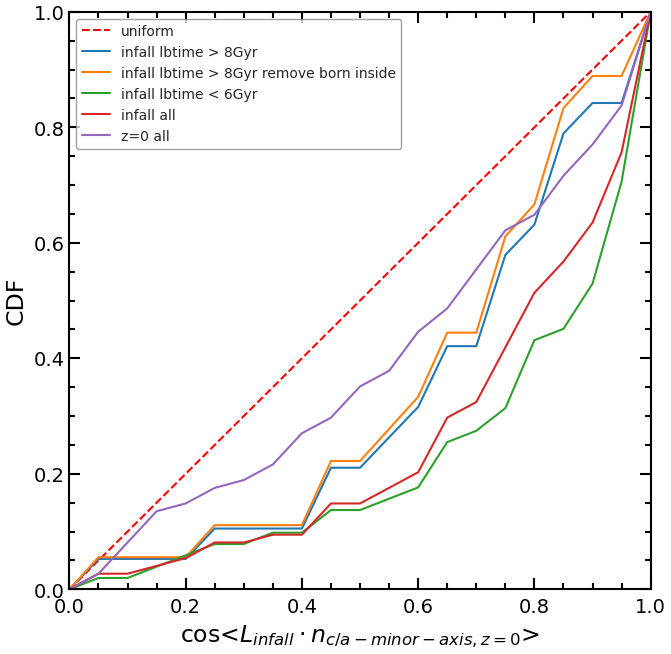

In [ ]:
# xlabel = 'cos<$L_{infall}\cdot n_{dm halo minor,z=0}$>'
# xlabel = r'cos<$L_{infall}\cdot n_{\alpha8-axis,z=0}$>'
xlabel = r'cos<$L_{infall}\cdot n_{c/a-minor-axis,z=0}$>'
draw_cdf(data = [angle_r200_infall_early, 
                 angle_r200_early_remove_born,angle_r200_infall_late, 
                 angle_satellite_L_infall, 
                 np.array(angle_l[-2])[is_within_r200]], 
         legends =["infall lbtime > 8Gyr", 
                   "infall lbtime > 8Gyr remove born inside", 
                   "infall lbtime < 6Gyr", 
                   "infall all",
                   "z=0 all"],
         xlabel = xlabel,
         title = 'depedence on infall time', 
         save = True)

In [ ]:
satellite_R200.shape

(98,)

In [ ]:
sort = np.argsort(satellite_mstar[is_within_r200][:,0])
bring_by_lmc = np.full(sum(is_within_r200),False)
lmc_index = sort[-1]
lmc_infall_index = infall_index[lmc_index]
# lmc_r200 = 227.2 * (satellite_mhalo[is_within_r200][lmc_index, lmc_infall_index]/1.252e12)**0.3333
lmc_r200 = satellite_R200[is_within_r200][lmc_index]
print("lmc_r200=", lmc_r200)
for i in range(len(satellite_pos_r200)):
    distance_to_lmc = np.linalg.norm(satellite_pos_r200[i][lmc_infall_index] - satellite_pos_r200[lmc_index][lmc_infall_index])
    # print(distance_to_lmc)
    if  distance_to_lmc < lmc_r200:
        bring_by_lmc[i] = True
print("num bring by lmc=", sum(bring_by_lmc))

lmc_r200= 157.36134338378906
num bring by lmc= 35


In [ ]:
sort = np.argsort(satellite_mstar[is_within_r200][:,0])
bring_by_smc = np.full(sum(is_within_r200),False)
smc_index = sort[-2]
smc_infall_index = infall_index[smc_index]
# smc_r200 = 227.2 * (satellite_mhalo[is_within_r200][smc_index, smc_infall_index]/1.252e12)**0.3333
smc_r200 = satellite_R200[is_within_r200][smc_index]
print("smc_r200=", smc_r200)
for i in range(len(satellite_pos_r200)):
    distance_to_smc = np.linalg.norm(satellite_pos_r200[i][smc_infall_index] - satellite_pos_r200[smc_index][smc_infall_index])
    # print(distance_to_smc)
    if  distance_to_smc < smc_r200:
        bring_by_smc[i] = True
print("num bring by smc=",sum(bring_by_smc))

smc_r200= 126.66051483154297
num bring by smc= 32


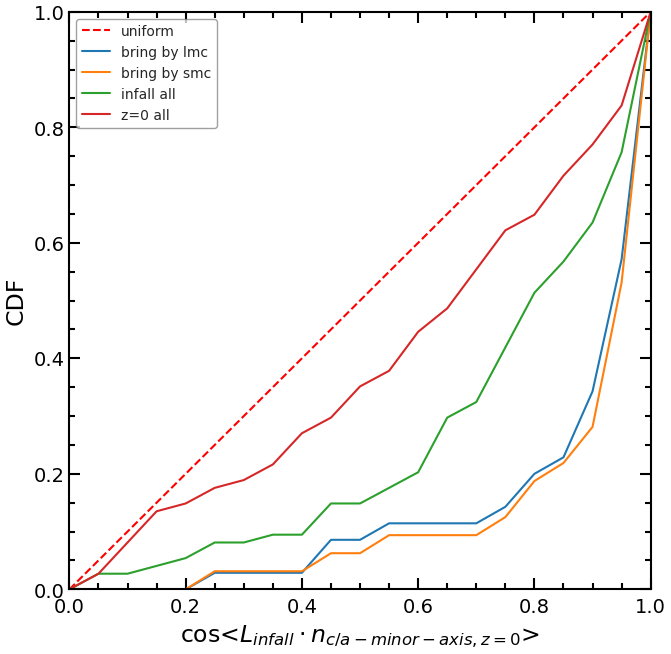

In [ ]:
L_bring_by_lmc_infall = satellite_L_infall[bring_by_lmc]
angle_bring_by_lmc_infall = abs(np.dot(L_bring_by_lmc_infall, e3_2))
L_bring_by_smc_infall = satellite_L_infall[bring_by_smc]
angle_bring_by_smc_infall = abs(np.dot(L_bring_by_smc_infall, e3_2))


draw_cdf([angle_bring_by_lmc_infall, 
          angle_bring_by_smc_infall, 
          angle_satellite_L_infall, 
          np.array(angle_l[-2])[is_within_r200]], 
        ["bring by lmc", "bring by smc", "infall all","z=0 all"],
        title = 'LMC & SMC influence',
        # xlabel = r'cos<$L_{infall}\cdot n_{\alpha8-axis,z=0}$>',
        xlabel = r'cos<$L_{infall}\cdot n_{c/a-minor-axis,z=0}$>',
        save=True)

In [ ]:
import pandas as pd

data = {'simulation_num': np.full(len(infall_lbtime), simulation_num),
        'infall_lbtime':infall_lbtime,
        'angle_satellite_L_infall':angle_satellite_L_infall,
        'z=0 all':np.array(angle_l[-2])[is_within_r200],
        'bring_by_lmc':bring_by_lmc,
        'bring_by_smc':bring_by_smc}

df = pd.DataFrame(data)

In [ ]:
df

,simulation_num,infall_lbtime,angle_satellite_L_infall,z=0 all,bring_by_lmc,bring_by_smc
0,2,1.366229,0.151500,0.117154,False,False
1,2,1.875217,0.685251,0.463488,False,False
2,2,1.875217,0.613885,0.114794,False,False
3,2,2.388623,0.995750,0.962220,True,True
4,2,2.517505,0.915221,0.632747,True,True
...,...,...,...,...,...,...
69,2,2.388623,0.969954,0.944699,True,True
70,2,2.259931,0.991261,0.921015,True,True
71,2,2.388623,0.999217,0.845635,True,True
72,2,2.517505,0.829000,0.242394,True,True


In [170]:
df_saved = pd.read_csv('satellite_infall_data_new.csv')
df_ = df_saved.append(df)
df_.to_csv('satellite_infall_data_new.csv',index=False)

/tmp/ipykernel_141721/3391613606.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df_saved.append(df)
